In [1]:
import pandas as pd
import seaborn as sns
from mpmath import *
from sympy import *

import numpy as np
from numpy import linalg as LA
from random import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from attacks import *
from defenses import *

In [41]:
from benchmark_helper import show_adversarial_sample
from benchmark_helper import benchmark_attack_by_model
from benchmark_helper import benchmark_defense_by_model
from benchmark_helper import benchmark_attack_models_visual
from benchmark_helper import benchmark_defense_models_visual
from benchmark_helper import get_adv_by_model_norm
from benchmark_helper import compare_model_for_two_inputs
from benchmark_helper import *

In [4]:
normalization = 255
width = 28
heigth = 28

In [5]:
def normalize(X):
    return X / normalization

In [6]:
def denormalize(X):
    return X * normalization

In [7]:
def to_image_shape(X):
    return np.array(X).reshape(-1, width, heigth)

In [8]:
def to_vector_shape(X):
    return np.array(X).reshape(-1, width * heigth)

In [9]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
X = X.to_numpy()
y = y.to_numpy()
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


In [11]:
X_test_images = to_image_shape(X_test)

#### Show images

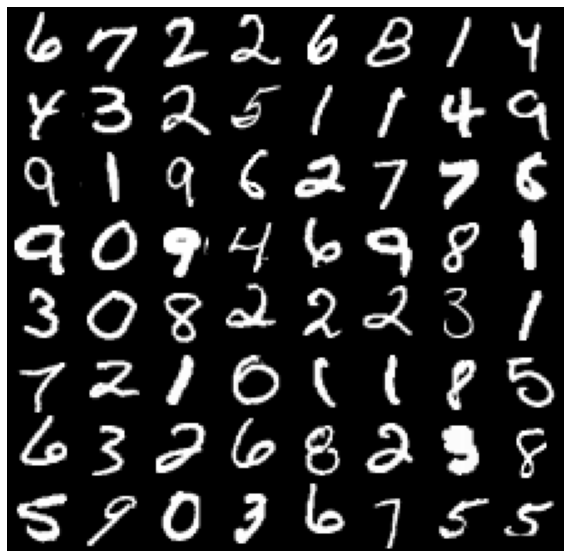

In [52]:
def show_samples(X, nrows=5, ncols=5, rsize=5, csize=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': -0.029, 'wspace': -0.029}, figsize=(rsize, csize))

    counter=0
    for row in ax:
        for col in row:
            col.imshow(X[counter], 'gray')
            col.axis('off')
            counter += 1
    plt.show()
    fig.savefig("../CourseWorkLatex/resources/minist_dataset.pdf", bbox_inches = 'tight', pad_inches = 0)
    
X_show = X_train.reshape(-1,28,28)
show_samples(X_show, nrows=8, ncols=8, rsize=10, csize=10)

#### One Hot Encoding

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

encoder.fit(y_test)
Y_test = encoder.transform(y_test).toarray()

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

def custom_scorer(estimator, X, Y):
    # transform from one hot encoding to label encoding 
    y_true = np.argmax(Y, axis=1)
    y_pred = estimator.predict(X)
    return accuracy_score(y_true, y_pred)

#### Hyperparameters selection

In [15]:
# from sklearn.model_selection import GridSearchCV
# #from LogisticRegression import CustomLogisticRegression

# model_params = dict(
#                 normalize=[False],
#                 learning_rate=[0.1, 0.01], 
#                 num_iters=[100, 300, 500],
#                 batch_size=[64, 128, 1024, -1],
#                 momentum=[0, 0.5, 0.9]
# )
# model = CustomLogisticRegression()
# grid = GridSearchCV(estimator=model, param_grid=model_params, scoring=custom_scorer, cv=2, n_jobs=-1)

In [16]:
# %%time
# grid.fit(normalize(X_train), Y_train)
#{'learning_rate': 0.1, 'num_iters': 200, 'batch_size': 128, 'momentum': 0.5, 'normalize': False}

In [17]:
# res = [print(f"{key}: {val}") for key, val in grid.best_params_.items()]

In [18]:
import numpy as np
from numpy import linalg as LA
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

import numpy as np
from numpy import linalg as LA
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class CustomLogisticRegression():
    def __init__(self, 
                 normalize=True, 
                 learning_rate=0.1, 
                 num_iters=200, 
                 epsilon=1e-10, 
                 batch_size=1024, 
                 momentum=0.9):
        
        self.normalize = normalize
        self.__mean = None
        self.__std = None
        
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.momentum = momentum
        

    def get_mean(self):
        return self.__mean
    
    def get_std(self):
        return self.__std
    
    def fit(self, X_vert, Y_vert):
        # X transformations
        if self.normalize == True:
            self.X_ = self.__normalize(X_vert)
        else:
            self.X_ = X_vert
        self.X_ = self.X_.T
 
        # Y transformations
        self.Y_ = Y_vert.T
        #self.W = np.random.randn(self.X_.shape[0], self.Y_.shape[0]) / np.sqrt(self.Y_.shape[0])
        self.W = np.full((self.X_.shape[0], self.Y_.shape[0]), 0.01)
        self.b = 0.0
        self.W, self.b, self.Js = self.__gradient_descent(
            self.X_, self.Y_, self.W, self.b, self.learning_rate, self.num_iters, self.epsilon, self.momentum, self.batch_size
        )

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
    
        y_pred = np.zeros(z.shape[1], dtype=int)
        for i in range(z.shape[1]):
            y_pred[i] = np.argmax(z[:, i])    
        
        return y_pred

    def predict_proba(self, X):
         # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
            return z, np.dot(self.W.T,X_norm.T)+self.b
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
            return z, np.dot(self.W.T,X.T)+self.b
 

    
    def predict_by_labels(self, X, y_labels):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
            
        y_pred = np.full((z.shape[1]), {})
        for i in range(z.shape[1]):
            y_pred[i] = { y_labels[j]: z[j][i] for j in range(z.shape[0])}
        return y_pred
            
    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def __normalize(self, X):
        if self.__mean is None and self.__std is None:
            mean = np.zeros([X.shape[1]])
            std  = np.ones([X.shape[1]])
            
            for i in range(X.shape[1]):
                if (np.std(X.iloc[:, i]) != 0):
                    mean[i] = np.mean(X.iloc[:, i])
                    std[i] = np.std(X.iloc[:, i])
            
            self.__mean = mean
            self.__std = std

        X_new = (X - self.__mean) / self.__std
        return X_new

    def __cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def __cross_entropy(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (-1 / m) * np.sum(Y.T * np.log(A.T))
        return J
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)

    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)

    def __forward_backward_propagation(self, X, Y, W, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        cost = self.__cross_entropy(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)
        self.derivative_weights = derivative_weights
        self.derivative_bias = derivative_bias
        return cost, derivative_weights, derivative_bias

    def __create_mini_batches(self, X, Y, batch_size):
        m = X.shape[1]

        if batch_size == -1:
            batch_size = m
                
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]        
        shuffled_Y = Y[:, permutation]

        mini_batches = []
        n_minibatches = m // batch_size
        
        for i in range(n_minibatches): 
            X_mini = shuffled_X[:, i * batch_size:(i + 1)*batch_size] 
            Y_mini = shuffled_Y[:, i * batch_size:(i + 1)*batch_size] 
            mini_batches.append((X_mini, Y_mini))
        if m % batch_size != 0:
            X_mini = shuffled_X[:, (i+1) * batch_size:m] 
            Y_mini = shuffled_Y[:, (i+1) * batch_size:m] 
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches
    
    def __gradient_descent(self, X, Y, W, b, learning_rate, num_iters, epsilon, momentum, batch_size):        
        # num of samples
        print(self.get_params())
        # num of features
        n = X.shape[1]

        J_history = []
        VdW = 0
        Vdb = 0
        for i in range(num_iters):
            mini_batches = self.__create_mini_batches(X, Y, batch_size) 
            for (X_mini, Y_mini) in mini_batches:
                J, delta_weights, delta_bias = self.__forward_backward_propagation(X_mini, Y_mini, W, b)
                
                VdW = (momentum * VdW + (1 - momentum) * delta_weights / (1 - momentum ** (i + 1)))
                Vdb = (momentum * Vdb + (1 - momentum) * delta_bias / (1 - momentum ** (i + 1)))
                
                W = W - learning_rate * VdW
                b = b - learning_rate * Vdb

            if i % 100 == 0:
                print(f"{i} iteration: {J}")

            J_history.append(J)

        return W, b, J_history
    
    def get_params(self, deep=True):
        return {
                "learning_rate": self.learning_rate,
                "num_iters": self.num_iters,
                "batch_size": self.batch_size,
                "momentum": self.momentum,
                "normalize": self.normalize
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### Model Training

In [19]:
from logistic_regression import CustomLogisticRegression

{'learning_rate': 1, 'num_iters': 200, 'batch_size': 1024, 'momentum': 0, 'normalize': False}
0 iteration: 0.4057576311305481
100 iteration: 0.2730634271185944


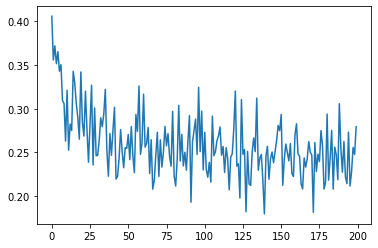

In [20]:
model_params = dict(
                normalize=False,
                learning_rate=1, 
                num_iters=200,
                batch_size=1024,
                momentum=0
)

lg = CustomLogisticRegression()
lg.set_params(**model_params)
lg.fit(normalize(X_train), Y_train)
plt.plot(lg.get_cost_history())


In [21]:
# fig, ax = plt.subplots(nrows=1, ncols=1,)
# ax.plot(lg.get_cost_history(), "-", color="orange")
# ax.set_title("")
# ax.set_xlabel("Кількість ітерацій")
# ax.set_ylabel("Функція втрати")



#### Prediction

In [26]:
y_pred = lg.predict(normalize(X_test))
accuracy_score(y_pred, y_test)

0.9182142857142858

#### Benchmark

In [23]:
# %%time
# defense_random = Randomization(resize_range=(-3, 3), pad_range=(0, 0))
# X_test_randomized = to_vector_shape(defense_random.get_defended(X_test_images))
# y_pred_randomized = lg.predict(normalize(X_test_randomized))
# accuracy_score(y_test, y_pred_randomized)

In [24]:
maps = np.zeros([10, 28, 28]) 

for label in range(10):
    w_ = lg.W[:, label].reshape(-1, 1)
    x_ =  X_train[np.where(y_train[:, 0] == label)] 
    res = np.mean(np.multiply(w_, normalize(x_.T)), axis=1)
    res = (res - np.min(res)) / (np.max(res) - np.min(res))
    res = res.reshape(28, 28)
    maps[label] = res

In [25]:
w * lg.derivative_weights[:, 0]


NameError: name 'w' is not defined

In [ ]:
plt.imshow(maps[2])

In [ ]:
# # w_ = lg.W[:, i].reshape(-1, 1)
# # x_ = X_train[np.where(y_train[:, 0] == i)]
# # res = np.mean(np.multiply(w_, normalize(x_.T)), axis=1)

# z, _ = lg.predict_proba(normalize(X_test))
# z.shape
# two_best = z[0].argsort()[-2:][::-1]
# two_best
# #two_best[:, 0]
# #np.mean(maps[two_best[:, 0]], axis=2)

a = np.mean(maps, axis=(0))
plt.imshow(a)


In [ ]:
from defenses import PixelDeflection

def find_best_deflect_params(X, Y_test, y_test, model=None, max_deflections=15, max_window=15, samples=100):
    min_result = 0
    d_ = 0
    w_ = 0
    count = 0
    
    for d in np.array(range(1, max_deflections)):
        for w in np.array(range(2, max_window)):
            defense_deflection = PixelDeflection(deflections=d, window=w)
            X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images[0:samples], rcam_prob=maps[0]))
            y_pred_deflected = model.predict(normalize(X_test_deflected))

            X1_res, X2_res = compare_model_for_two_inputs(
                X_test, X_test_deflected, Y_test, y_test, model=model, attack=AttackIFGSM, samples=samples, num_steps=10, visualize=False
            )
            if count == 0:
                min_result = X1_res

            if (X2_res < min_result):
                d_ = d
                w_ = w
                min_result = X2_res
            count += 1

    print(d_, w_)
    return d_, w_

label = 0
d, w = find_best_deflect_params(X, Y_test, y_test, model=lg, max_window=15, max_deflections=15, samples=100)

In [ ]:
label=0
defense_deflection = PixelDeflection(deflections=10, window=10)
X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images,rcam_prob=np.mean(maps, axis=0)))
compare_model_for_two_inputs(X_test, X_test_deflected, Y_test, y_test, model=lg, attack=AttackIFGSM, samples=50, num_steps=30, visualize=True)

In [ ]:
defense_rand = Randomization(resize_window=1, pad_window=1)
X_test_rand = to_vector_shape(defense_rand.get_defended(X_test_images[0:100]))
print(accuracy_score(lg.predict(normalize(X_test_rand)), y_test[0:100]))
a, b = compare_model_for_two_inputs(X_test, X_test_rand, Y_test, y_test, model=lg, attack=AttackFGSM, samples=100, num_steps=30)

In [ ]:
benchmark_defense_models_visual(X_test, Y_test, y_test, model=lg, samples=100, num_steps=30)

In [ ]:
def benchmark_attack_models_visual(X, y_labels, model=None, samples=100, num_steps=10):
    x1, y1, label1 = benchmark_attack_by_model(X, y_labels, model=model, attack_model=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_attack_by_model(X, y_labels, model=model, attack_model=AttackIFGSM, samples=samples, num_steps=num_steps)
    x3, y3, label3 = benchmark_attack_by_model(X, y_labels, model=model, attack_model=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_attack_by_model(
        X, y_labels, model=model, attack_model=AttackDeepFool, samples=samples, num_steps=num_steps
    )

    fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Perturbation vs Accuracy Rate')
    ax.set_xlabel(r"Perturbation $\epsilon$")
    ax.set_ylabel('Accuracy (%)')

    plt.plot(np.array(x1), y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = label1)
    plt.plot(np.array(x2), y2, linestyle='--', marker='o', markersize=2, color='#2300A8', label = label2)
    plt.plot(np.array(x3), y3, linestyle='--', marker='o', markersize=2, color='red', label = label3)
    plt.plot(np.array(x4), y4, linestyle='--', marker='o', markersize=2, color='orange', label = label4)

    plt.legend()


In [ ]:
benchmark_attack_models_visual(X_test, y_labels, model=lg, samples=100, num_steps=10)

In [ ]:
def get_rmap(X, Y_true, y_true, model=None, attack=None, samples=100):
    X_normalize = normalize(X[0:samples])
    y_true = y_true[0:samples].reshape(samples)

    X_adv = get_adv_by_model_norm(X_normalize, Y_true, model=model, attack=attack, norm=0.5)
    return np.sum(X_normalize[0:samples] - X_adv, axis=0)

img = get_rmap(X_test, Y_test, y_test, model=lg, attack=AttackDeepFool, samples=100)

img = (img-np.min(img, axis=0))/(np.max(img, axis=0)-np.min(img, axis=0))
plt.imshow(img.reshape(28, 28))
sns.heatmap(img.reshape(28, 28))

#### RMAP

In [ ]:
# X_test.iloc[0, :].shape

# avg = 0
# for i in range(X_test.shape[0]):
#     attack = AttackFGSM()
#     x_ = normalize(np.expand_dims(X_test.iloc[i, :], axis=0))
#     a = attack.attack(x_, lg.W, lg.b, y, lg.predict, max_norm=1)
#     avg = avg + (x_ - a)
    

In [ ]:
# #avg = avg / X_test.shape[0]
# #plt.imshow(avg.reshape(28, 28))
# #avg
# denormalize(avg) / X_test.shape[0]
# rmap = abs((avg / X_test.shape[0]).reshape(28, 28))
# plt.imshow(rmap, 'gray')
# rmap[15]

In [ ]:
# x_ = X_test.to_numpy().reshape(-1, 28,28)[0]
# res = pixel_deflection_with_map(x_, avg.reshape(-28, 28), 100, 20)
# plt.imshow(res)

In [ ]:
# avg = avg / X_test.shape[0]
# plt.imshow(avg.reshape(28, 28))

In [33]:
correct_pred_idx = lg.predict(normalize(X_test)) == y_test[:, 0]

#### Untargeted Noise Attack

In [ ]:
# index = 38
# x = np.expand_dims(X_test[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_norm=1)

#### Untargeted FGSM

In [ ]:
# index = 0
# x = np.expand_dims(X_test[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_norm=0.2)

#### Untargeted I-FGSM

In [ ]:
index = 1
x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.04, max_iters=100)

#### DeepFool

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.15, max_iters=12)

#### Targeted I-FGSM

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))
# y[9] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_norm=0.2, max_iters=5000)

#### Untargeted MI-FGSM

In [ ]:
# index = 123
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackMIFGSM, max_norm=1, max_iters=5000)

[0.0, 8.0, 17.7, 33.1, 52.300000000000004, 69.0, 82.8, 91.4, 95.89999999999999, 97.7, 98.8, 98.9, 99.3, 99.7, 99.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.0, 8.0, 19.0, 35.5, 56.99999999999999, 73.5, 86.0, 93.4, 97.0, 98.4, 99.2, 99.4, 99.7, 99.9, 99.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.0, 8.0, 19.0, 35.4, 56.89999999999999, 73.5, 86.0, 93.4, 97.0, 98.4, 99.2, 99.4, 99.7, 99.9, 99.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.0, 3.6999999999999997, 8.6, 18.099999999999998, 29.7, 44.4, 58.5, 70.0, 77.8, 83.6, 88.0, 91.0, 93.30000000000001, 95.0, 96.6, 97.8, 98.3, 98.5, 98.7, 99.1, 99.2, 99.4, 99.6, 99.7, 99.7, 99.7, 99.8, 99.9, 99.9, 99.9]


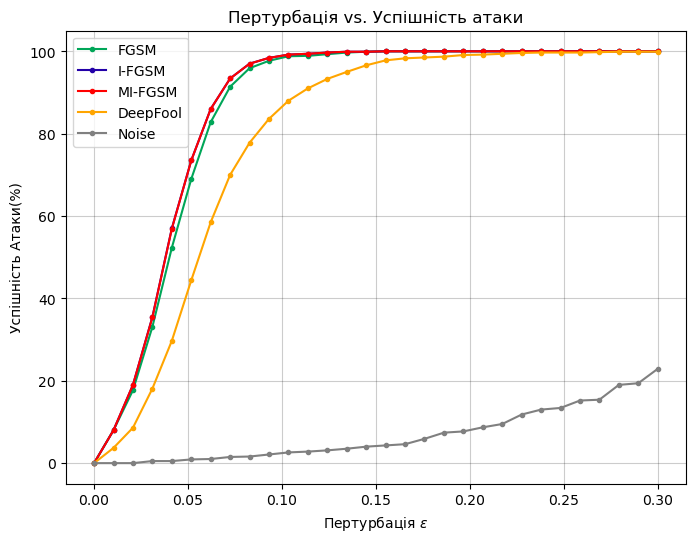

In [30]:
def benchmark_attack_by_model(X, y_labels, model=None, attack=None, samples=100, num_steps=15):
    X_norm = normalize(X)
    iter_res_dict = {}

    norms_range = np.linspace(0, 0.3, num=num_steps)

    for i in range(samples):
        x_normalized = np.expand_dims(X_norm[i, :], axis=0)
        y = np.zeros(len(y_labels))
        true_class_pos = model.predict(x_normalized)
        y[true_class_pos] = 1
    
        for norm in norms_range:
            atck = attack()
            if type(atck).__name__ in ['AttackNoise']:
                atck.attack(x_normalized, y, model.predict, max_norm=norm)
            elif type(atck).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackDeepFool', 'AttackFGSM']:
                atck.attack(x_normalized, model.W, model.b, y, model.predict, max_norm=norm)
            
            elif type(atck).__name__ in ['AttackMIFGSM']:
                atck.attack(x_normalized, model.W, model.b, y, model.predict, max_norm=norm, momentum=0.89)
        
            success = atck.tricked
            
            if norm in iter_res_dict.keys():
                iter_res_dict[norm]["appearance_count"] += 1
                iter_res_dict[norm]["success_count"] += success
            else:
                iter_res_dict.update({norm: {"appearance_count": 1, "success_count": success} })

    success_rate = {}
    for key, value in iter_res_dict.items():
        success_rate[key] = value["success_count"] / value["appearance_count"] * 100

    perturbations_list = [x[0] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]
    successrate_list = [x[1] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]

    return perturbations_list, successrate_list, type(atck).__name__


def benchmark_attack_models_visual(X, y_true, y_labels, model=None, samples=100, num_steps=10):    
    y_correct_idx = (model.predict(normalize(X)) == y_true[:, 0])
    x1, y1, label1 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackIFGSM, samples=samples, num_steps=num_steps)
    x3, y3, label3 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_attack_by_model(
        X[y_correct_idx], y_labels, model=model, attack=AttackDeepFool, samples=samples, num_steps=num_steps
    )
    x5, y5, label5 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackNoise, samples=samples, num_steps=num_steps)
    
    fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Пертурбація vs. Успішність атаки')
    ax.set_xlabel(r"Пертурбація $\epsilon$")
    ax.set_ylabel('Успішність Атаки(%)')

    print(y1)
    print(y2)
    print(y3)
    print(y4)
    plt.plot(np.array(x1), y1, linestyle='-', marker='o', markersize=3, color='#00A658', label = "FGSM")
    plt.plot(np.array(x2), y2, linestyle='-', marker='o', markersize=3, color='#2300A8', label = "I-FGSM")
    plt.plot(np.array(x3), y3, linestyle='-', marker='o', markersize=3, color='red', label = "MI-FGSM")
    plt.plot(np.array(x4), y4, linestyle='-', marker='o', markersize=3, color='orange', label = "DeepFool")
    plt.plot(np.array(x5), y5, linestyle='-', marker='o', markersize=3, color='gray', label = "Noise")

    plt.legend()
    fig.savefig("../CourseWorkLatex/resources/attacks_bench_8_6.pdf", bbox_inches = 'tight', pad_inches = 0)

benchmark_attack_models_visual(X_test, y_test, y_labels, model=lg, samples=1000, num_steps=30)

[0.921 0.848 0.758 0.615 0.434 0.281 0.155 0.076 0.033 0.019 0.01  0.009
 0.006 0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
[0.921 0.848 0.747 0.593 0.388 0.24  0.124 0.057 0.024 0.012 0.007 0.005
 0.003 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
[0.921 0.848 0.747 0.595 0.389 0.241 0.124 0.058 0.024 0.012 0.007 0.005
 0.003 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
[0.921 0.888 0.845 0.758 0.65  0.513 0.377 0.277 0.206 0.154 0.114 0.086
 0.064 0.049 0.034 0.022 0.017 0.015 0.014 0.011 0.011 0.009 0.007 0.006
 0.006 0.007 0.005 0.004 0.004 0.004]


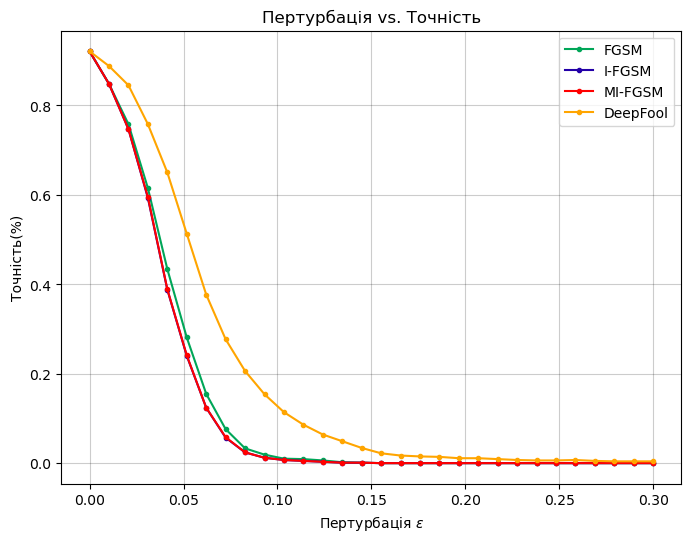

In [31]:
def benchmark_defense_by_model(X, Y_true, y_true, model=None, attack=None, samples=100, num_steps=0, a=0, b=0.3):
    norms = np.linspace(a, b, num=num_steps)
    scores = np.zeros(norms.shape)

    for idx, norm in enumerate(norms):
        X_normalize = normalize(X[0:samples])
        y_true = y_true[0:samples].reshape(samples)

        X_adv = get_adv_by_model_norm(X_normalize, Y_true, model=model, attack=attack, norm=norm)
        scores[idx] = accuracy_score(model.predict(X_adv), y_true)
    return norms, scores, attack.__name__


def benchmark_defense_models_visual(X, Y_true, y_true, model=None, samples=100, num_steps=10):
    x1, y1, label1 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackIFGSM, samples=samples, num_steps=num_steps)
    x3, y3, label3 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_defense_by_model(
        X, Y_true, y_true, model=model, attack=AttackDeepFool, samples=samples, num_steps=num_steps
    )


    fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Пертурбація vs. Точність')
    ax.set_xlabel(r"Пертурбація $\epsilon$")
    ax.set_ylabel('Точність(%)')
    print(y1)
    print(y2)
    print(y3)
    print(y4)
    plt.plot(np.array(x1), y1, linestyle='-', marker='o', markersize=3, color='#00A658', label = "FGSM")
    plt.plot(np.array(x2), y2, linestyle='-', marker='o', markersize=3, color='#2300A8', label = "I-FGSM")
    plt.plot(np.array(x3), y3, linestyle='-', marker='o', markersize=3, color='red', label = "MI-FGSM")
    plt.plot(np.array(x4), y4, linestyle='-', marker='o', markersize=3, color='orange', label = "DeepFool")
    plt.legend()
    fig.savefig("../CourseWorkLatex/resources/defenses_bench_8_6.pdf", bbox_inches = 'tight', pad_inches = 0)

benchmark_defense_models_visual(X_test, Y_test, y_test, model=lg, samples=1000, num_steps=30)

In [37]:
def show_adversarial_sample(x, y_labels, true_class=[], model=None, attack_model=None, max_norm=10, max_iters=10):

    x_normalized = normalize(x)
    attack = attack_model()

    if type(attack).__name__ in ['AttackNoise']:
        x_adv_normalized = attack.attack(x_normalized, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackFGSM', 'AttackDeepFool', 'AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm, momentum=0.1)
        
    x_adv = denormalize(x_adv_normalized)
    x_adv_pred = model.predict(np.array(x_adv_normalized))
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(30, 30), nrows=1, ncols=3, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': 0, 'wspace': 0}, dpi=100, facecolor='w')
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True)
    fig.set_size_inches(15,5)
#     fig.suptitle('Змагальний приклад')
    
    ax1.imshow(x.reshape(28,28), 'gray')
    ax1.set_title(r"Оригінальний приклад "+
                  r"$X$"+
                  "\n Передбачення: "+
                  f"{model.predict(x_normalized)[0]}")
    
    ax2.imshow(x.reshape(28,28) - x_adv.reshape(28,28), "gray")
    ax2.set_title(r"$\|\|X - X^{*}\|\| \leq \varepsilon$, $\varepsilon$=" + f"{max_norm}")
    
    ax3.imshow(x_adv.reshape(28,28), 'gray')
    ax3.set_title("Змагальний приклад "+
                  r"$X^{*}$"+
                  "\n Передбачення: "+
                  f"{x_adv_pred[0]}")
    plt.show()
    fig.savefig("../CourseWorkLatex/resources/i-fgsm-example.pdf", bbox_inches = 'tight', pad_inches = 0)
    #pred_with_labels = model.predict_by_labels(np.array(x_adv_normalized), y_labels)
    #plt.bar(pred_with_labels[0].keys(), pred_with_labels[0].values())
    #plt.show()

    #print(f"Norm_inf: {LA.norm(abs(x_normalized - x_adv_normalized), np.inf)}; Result: {attack.tricked}")
    #print(f"Max value: {max(max(x_adv))}")
    #print(f"Min value: {min(min(x_adv))}")

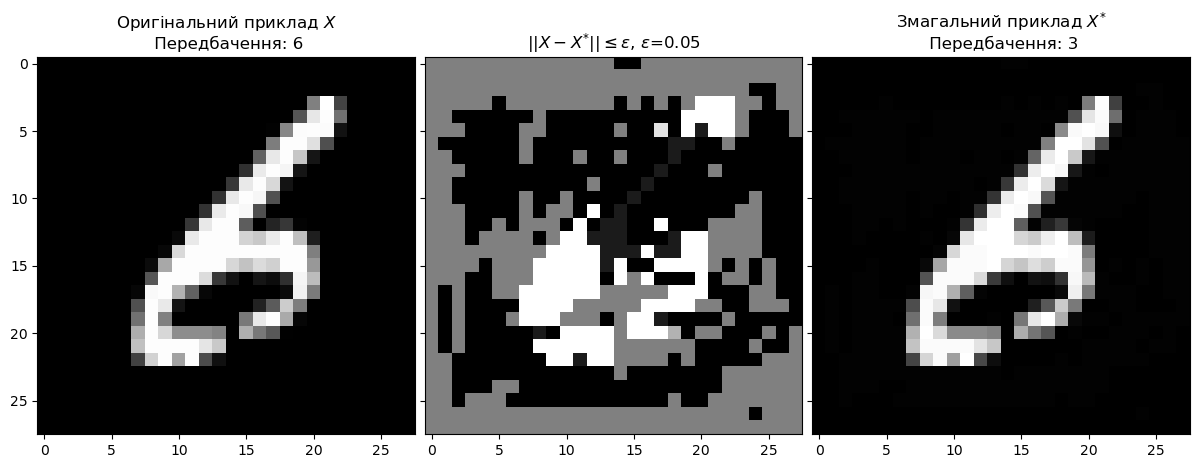

In [38]:
index = 10
x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.05, max_iters=100)

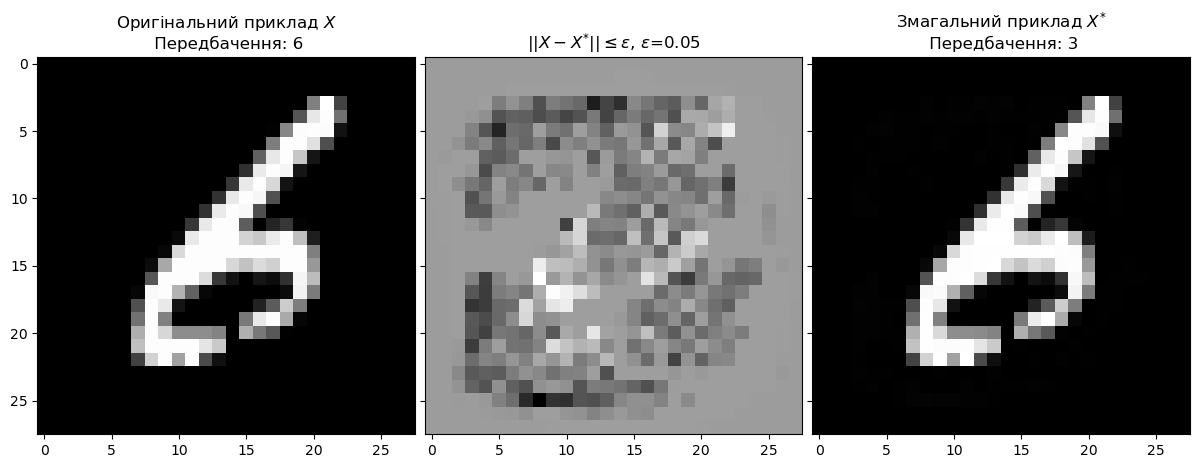

In [36]:
index = 10
x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.05, max_iters=100)

In [ ]:
def compare_model_for_two_inputs(X1, X2, Y_true, y_true, model=None, attack=None, samples=100, num_steps=30, visualize=True):
    x1, y1, label1 = benchmark_defense_by_model(X1, Y_true, y_true, model=model, attack=attack, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_defense_by_model(X2, Y_true, y_true, model=model, attack=attack, samples=samples, num_steps=num_steps)
    
    if visualize:
        fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w')
        plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
        ax.set_title('I-FGSM')
        ax.set_xlabel(r"Пертурбація $\epsilon$")
        ax.set_ylabel('Точність (%)')

        plt.plot(x1, y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = f"чисті приклади")
        plt.plot(x2, y2, linestyle='--', marker='o', markersize=2, color='#2300A8', label = f"захищені приклади")
        plt.legend()
        
    a = round(sum(y1/num_steps), 4)
    b = round(sum(y2/num_steps), 4)
    return a,b

In [ ]:
X_adv = get_adv_by_model_norm(normalize(X_test), Y_test, model=lg, attack=AttackFGSM, norm=0.1)


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': -0.68, 'wspace': -0.02}, figsize=(10, 10))
i = 0
for row in ax:
    for col in row:
        w_ = lg.W[:, i].reshape(-1, 1)
        x_ = X_train[np.where(y_train[:, 0] == i)]
        res = np.mean(np.multiply(w_, normalize(x_.T)), axis=1)
        col.imshow(res.reshape(28, 28), cmap='viridis')
        col.axis('off')
        col.set_title(i)
        i += 1

fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax, fraction=0.022, pad=0.015)


#img = plt.imshow(np.array([[0,1]]), cmap="Oranges")
#img.set_visible(False)
#plt.colorbar(orientation="vertical")
fig.savefig("../CourseWorkLatex/resources/classactivationmap.pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
def benchmark_defense_by_model(X, Y_true, y_true, model=None, attack=None, samples=100, num_steps=0, a=0, b=0.3):
    norms = np.linspace(a, b, num=num_steps)
    scores = np.zeros(norms.shape)

    for idx, norm in enumerate(norms):
        X_normalize = normalize(X[0:samples])
        y_true = y_true[0:samples].reshape(samples)

        X_adv = get_adv_by_model_norm(X_normalize, Y_true, model=model, attack=attack, norm=norm)
        scores[idx] = accuracy_score(model.predict(X_adv), y_true)
    return norms, scores, attack.__name__